# GeoNet FDSN webservice with Obspy demo - Dataselect service

In this tutorial we will get the wavefrom data from one station. By the end of this notebook you should be able to make a graph like the one below. <img src="day_plot.png" height="500" width="500">

This demo introduces some simple code that requests data using [GeoNet's FDSN webservices](http://www.geonet.org.nz/data/tools/FDSN) and the [obspy module](https://github.com/obspy/obspy/wiki) in python. This notebook uses Python 3. 

### Getting Started - Import Modules

In [2]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client as FDSN_Client

### Define GeoNet FDSN client
Two client's are defined below.
 - The archive client, this is as complete as possible but 7 days behind present for the waveform service (dataselect)
 - The near real-time client, this is as fast as possible but may not be complete. It only contains the last 8 days of waveforms.

In [3]:
client = FDSN_Client("GEONET")
client_nrt = FDSN_Client("https://service-nrt.geonet.org.nz")

## Accessing Waveforms
Use the **dataselect** service to access waveforms from the archive.

Data is returned as a stream object, which is made up of a number of traces. 

You can filter data requests by time, station, channel, etc, and you can use UNIX wildcards in the request.

This first example requests waveforms from the Kaikoura earthquake, recorded at THZ, near Nelson Lakes. This station includes both a seismometer and accelerometer. 

In [4]:
t = UTCDateTime("2016-11-13T11:02:30.000")
st = client.get_waveforms("NZ", "THZ","*", "H??", t, t + 300,attach_response=True)
print(st)

6 Trace(s) in Stream:
NZ.THZ.10.HHE | 2016-11-13T11:02:25.473189Z - 2016-11-13T11:07:31.073189Z | 100.0 Hz, 30561 samples
NZ.THZ.10.HHN | 2016-11-13T11:02:29.263189Z - 2016-11-13T11:07:30.483189Z | 100.0 Hz, 30123 samples
NZ.THZ.10.HHZ | 2016-11-13T11:02:23.953190Z - 2016-11-13T11:07:31.293190Z | 100.0 Hz, 30735 samples
NZ.THZ.20.HNE | 2016-11-13T11:02:29.690000Z - 2016-11-13T11:07:30.925000Z | 200.0 Hz, 60248 samples
NZ.THZ.20.HNN | 2016-11-13T11:02:29.770000Z - 2016-11-13T11:07:30.145000Z | 200.0 Hz, 60076 samples
NZ.THZ.20.HNZ | 2016-11-13T11:02:29.580000Z - 2016-11-13T11:07:30.170000Z | 200.0 Hz, 60119 samples


In [5]:
st[0:3].plot()
st[3:6].plot()

<Figure size 800x750 with 3 Axes>

<Figure size 800x750 with 3 Axes>

Note in the original request to get the waveforms, we set "attach_response" equal to True. This is extremely useful for analysis, such as geting the maximum amplitudes.

The example below removes the response from the acceleration records so that we can determine the peak ground accelerations measured on each channel.

In [6]:
pre_filt = (0.025, 0.03, 70.0, 80.0)
acc = st[3:6]
acc.remove_response(output='ACC', pre_filt=pre_filt)
pga = acc.max()
print('PGA (HNE) = %f, PGA (HNN) = %f, PGA (HNZ) = %f m/s/s ' % (pga[0],pga[1],pga[2]))

PGA (HNE) = 0.402338, PGA (HNN) = 0.485368, PGA (HNZ) = -0.249306 m/s/s 


Another common request is to view an entire day worth of data at a site.

This example is from a volcanic swarm at Mt Ruapehu.

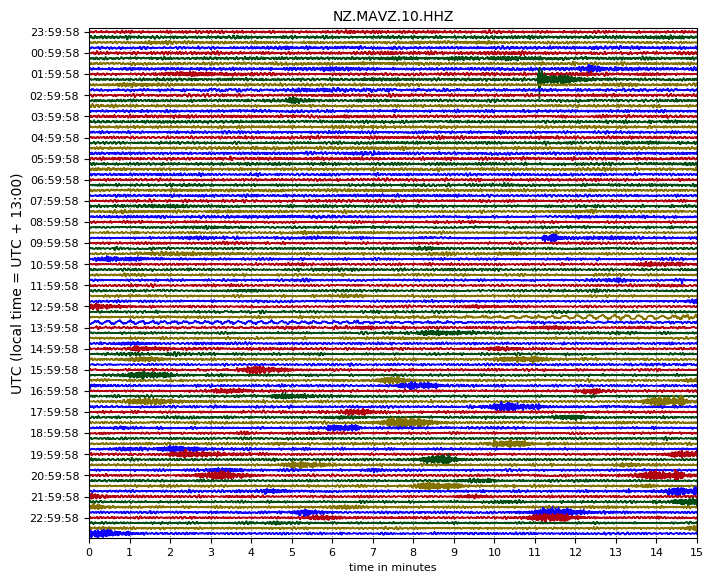

In [7]:
t = UTCDateTime("2016-04-27T00:00:00.000")
st = client.get_waveforms("NZ", "MAVZ","10", "HHZ", t, t + 86400)
st.plot(type="dayplot")

Spectrogram plots are also easy in with obspy...

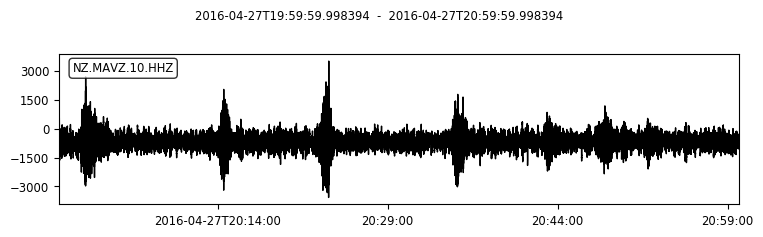

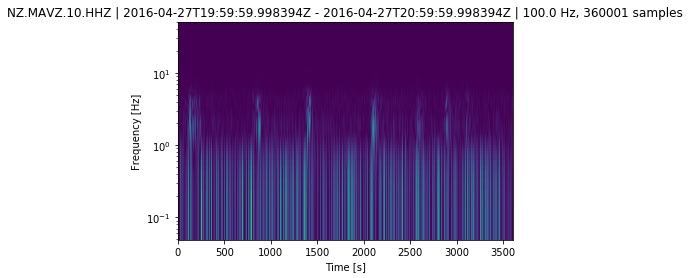

[None]

In [8]:
t = UTCDateTime("2016-04-27T20:00:00.000")
st.trim(t,t+3600)
st.plot()
st.spectrogram(log=True)

At the beginning of this workbook we defined two clients. One for the archive services, which we have been using so far, and the other for the near real-time service. 

The following example shows the last day of data recorded at a site. 

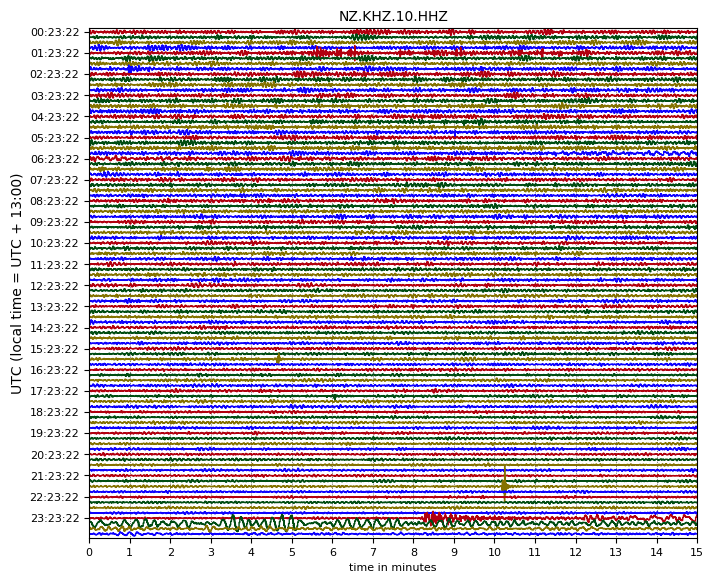

In [9]:
t = UTCDateTime.now()
st = client_nrt.get_waveforms("NZ", "KHZ", "10", "HHZ",t-86400,t)
st.plot(type="dayplot")

We can also get some basic attributes from the header of the miniseed to tell us a bit more about the data.

In [10]:
print(st[0].stats)

               network: NZ
               station: KHZ
              location: 10
               channel: HHZ
             starttime: 2018-12-06T00:23:22.848394Z
               endtime: 2018-12-07T00:23:16.688394Z
         sampling_rate: 100.0
                 delta: 0.01
                  npts: 8639385
                 calib: 1.0
_fdsnws_dataselect_url: https://service-nrt.geonet.org.nz/fdsnws/dataselect/1/query
               _format: MSEED
                 mseed: AttribDict({u'record_length': 512, u'encoding': u'STEIM2', 'filesize': 11620352, u'dataquality': u'D', u'number_of_records': 22696L, u'byteorder': u'>'})


And can use these attributes to determine the completeness of the data for that day. Our service will return slightly more data than the requested window so we need to trim it first.

In [11]:
st[0].trim(t-86400,t)
completeness = (st[0].stats.npts)/(st[0].stats.sampling_rate*86400)*100
print(st[0].stats.npts)
print('%f percent complete in the last day at %s' % (completeness, st[0].stats.station))

8639385
99.992882 percent complete in the last day at KHZ
